In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torchsummary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms.functional import resize, to_tensor, to_pil_image
from PIL import Image
from tqdm import tqdm
from utils_evaluate_model import *

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:1')
elif torch.mps.is_available():
    device = torch.device('mps')
    dtype = torch.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

cuda:1


In [3]:
path = "images/zebra.png"
im = Image.open(path).convert("RGB")
im_tensor = to_tensor(im).to(device=device)
print(f"inital tensor size : {im_tensor.shape}")


max_dim = 250
_, H, W = im_tensor.shape
scale_factor = max_dim / max(H, W)

new_H = int(H * scale_factor)
new_W = int(W * scale_factor)
im_resized = resize(im_tensor.unsqueeze(0), size=[new_H, new_W], antialias=True).squeeze(0) *2 -1

print(f"rescaled tensor size : {im_resized.shape}")

inital tensor size : torch.Size([3, 380, 572])
rescaled tensor size : torch.Size([3, 166, 250])


In [4]:

min_dim = 25            # dimension mini au coarse scale
N = 0
current_H, current_W = new_H, new_W
r = 4 / 3               # scaling factor (environ 1.333)

# Calculer N tel que le coarse scale soit >= min_dim
while current_H >= min_dim and current_W >= min_dim:
    N += 1
    current_H = int(current_H / r)
    current_W = int(current_W / r)
N

7

In [5]:
scales = [im_resized.unsqueeze(0)]    # niveau 0 = fine

for i in range(0, N-1):
    prev = scales[-1]
    _, _, h, w = prev.shape
    new_h = max(int(h / r), 1)
    new_w = max(int(w / r), 1)
    down = resize(prev, size=[new_h, new_w], antialias=True)
    scales.append(down)
    print(down.shape)
print(len(scales))

torch.Size([1, 3, 124, 187])
torch.Size([1, 3, 93, 140])
torch.Size([1, 3, 69, 105])
torch.Size([1, 3, 51, 78])
torch.Size([1, 3, 38, 58])
torch.Size([1, 3, 28, 43])
7


+ Générations des generateurs/discriminateurs

Number of scales N = 7
Scaling factor r = 1.333
Scale 0 : torch.Size([1, 3, 166, 250])


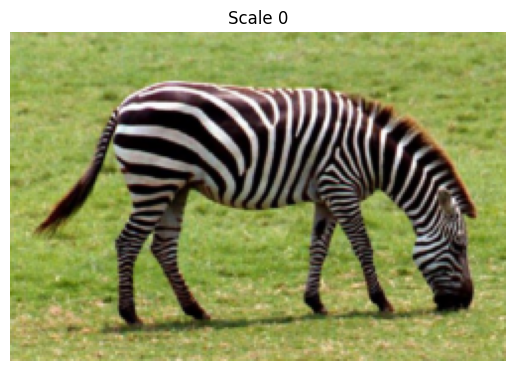

Scale 1 : torch.Size([1, 3, 124, 187])


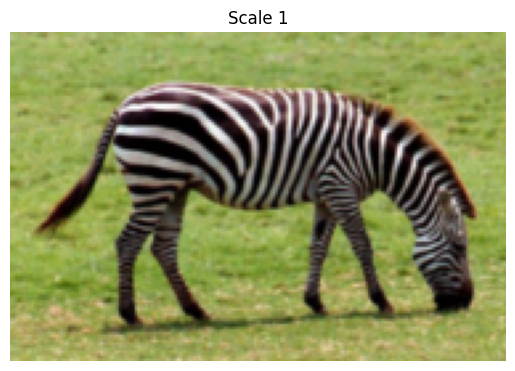

Scale 2 : torch.Size([1, 3, 93, 140])


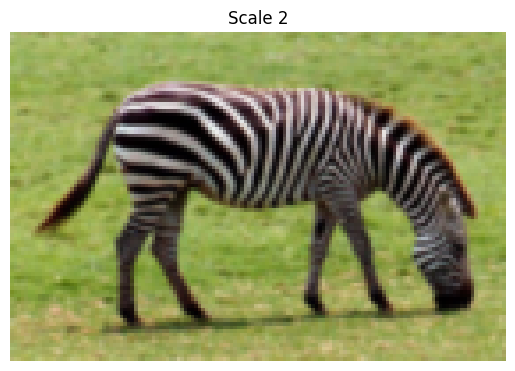

Scale 3 : torch.Size([1, 3, 69, 105])


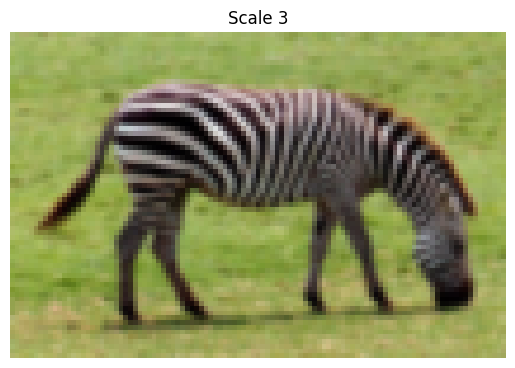

Scale 4 : torch.Size([1, 3, 51, 78])


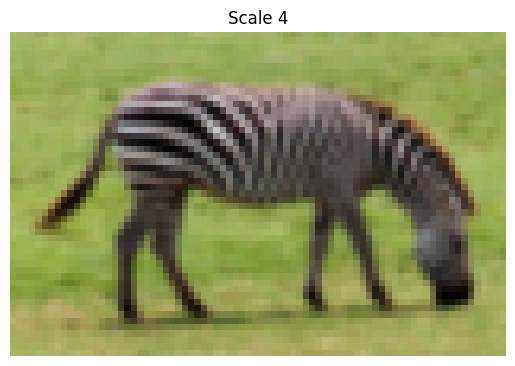

Scale 5 : torch.Size([1, 3, 38, 58])


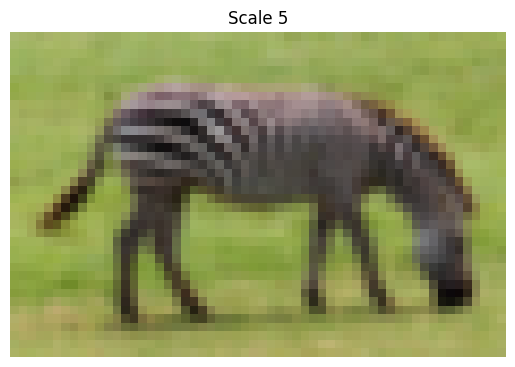

Scale 6 : torch.Size([1, 3, 28, 43])


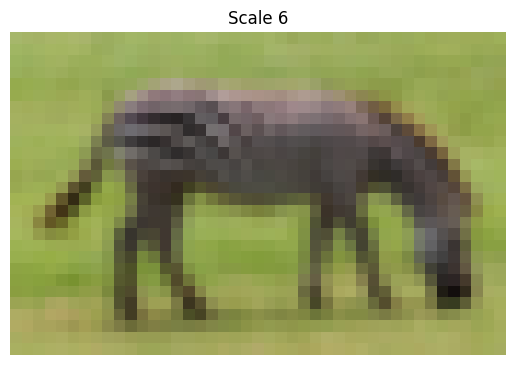

In [6]:
print(f"Number of scales N = {N}")
print(f"Scaling factor r = {r:.3f}")
for i, im_scale in enumerate(scales):
    print(f"Scale {i} : {im_scale.shape}")
    plt.imshow(pil_from_minus1to1(im_scale.squeeze().cpu()))
    plt.axis('off')
    plt.title(f"Scale {i}")
    plt.show()

+ Boucle d'entrainement 

In [7]:
hidden_lowest_dim = 32
Genarators = []
Discriminators = []

for i in range(len(scales)):
    u = N-i
    Genarators.append(Generator( hidden_lowest_dim *  2**(u//4)).to(device))
    Discriminators.append(Discriminator(hidden_lowest_dim * 2**(u//4)).to(device))
    

for gen in Genarators : 
     print(gen.n_hidden)
for dis in Discriminators:
     print(dis.n_hidden)

64
64
64
64
32
32
32
64
64
64
64
32
32
32


In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1 or classname.find('InstanceNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)




it scale 6:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 6 | it 0]  Lips ≈ 0.05
[scale 6 | it 0]  LR = 5.00e-04


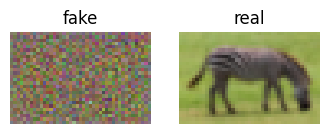

it scale 6:  10%|▉         | 199/2000 [00:11<01:35, 18.93it/s]

[scale 6 | it 200]  Lips ≈ 1.56
[scale 6 | it 200]  LR = 5.00e-04


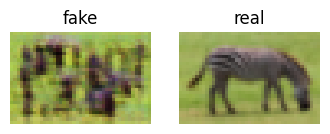

it scale 6:  20%|█▉        | 399/2000 [00:21<01:23, 19.09it/s]

[scale 6 | it 400]  Lips ≈ 1.15
[scale 6 | it 400]  LR = 5.00e-04


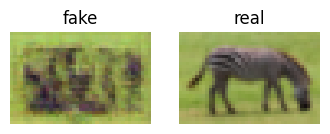

it scale 6:  30%|██▉       | 599/2000 [00:32<01:12, 19.26it/s]

[scale 6 | it 600]  Lips ≈ 1.18
[scale 6 | it 600]  LR = 5.00e-04


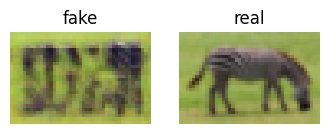

it scale 6:  40%|███▉      | 799/2000 [00:42<01:02, 19.24it/s]

[scale 6 | it 800]  Lips ≈ 1.42
[scale 6 | it 800]  LR = 5.00e-04


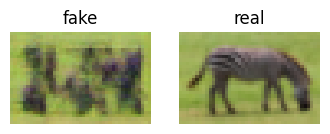

it scale 6:  50%|████▉     | 999/2000 [00:53<00:51, 19.32it/s]

[scale 6 | it 1000]  Lips ≈ 1.23
[scale 6 | it 1000]  LR = 5.00e-04


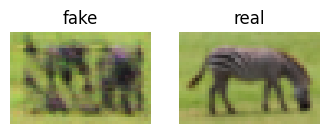

it scale 6:  60%|█████▉    | 1199/2000 [01:04<00:41, 19.21it/s]

[scale 6 | it 1200]  Lips ≈ 1.41
[scale 6 | it 1200]  LR = 5.00e-04


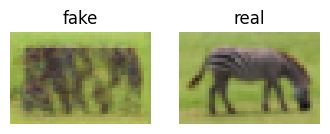

it scale 6:  70%|██████▉   | 1399/2000 [01:14<00:31, 19.10it/s]

[scale 6 | it 1400]  Lips ≈ 1.75
[scale 6 | it 1400]  LR = 5.00e-04


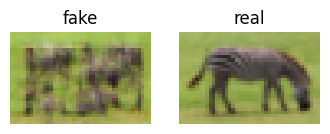

it scale 6:  80%|███████▉  | 1599/2000 [01:25<00:20, 19.25it/s]

[scale 6 | it 1600]  Lips ≈ 1.45
[scale 6 | it 1600]  LR = 5.00e-05


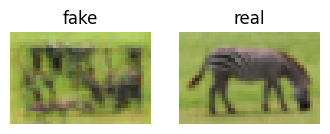

it scale 6:  90%|████████▉ | 1799/2000 [01:35<00:10, 19.11it/s]

[scale 6 | it 1800]  Lips ≈ 1.66
[scale 6 | it 1800]  LR = 5.00e-05


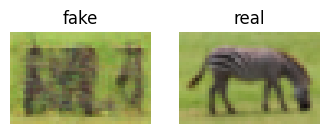

it scale 6: 100%|█████████▉| 1999/2000 [01:46<00:00, 18.37it/s]

[scale 6 | it 1999]  Lips ≈ 1.27
[scale 6 | it 1999]  LR = 5.00e-05


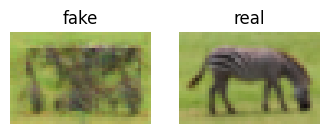

[init] copied weights from scale 6 → 5


it scale 5:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 5 | it 0]  Lips ≈ 1.44
[scale 5 | it 0]  LR = 5.00e-04


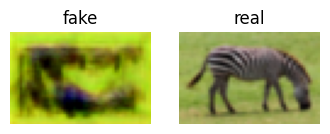

it scale 5:  10%|▉         | 199/2000 [00:10<01:36, 18.69it/s]

[scale 5 | it 200]  Lips ≈ 1.51
[scale 5 | it 200]  LR = 5.00e-04


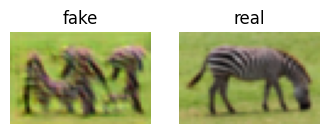

it scale 5:  20%|█▉        | 399/2000 [00:21<01:27, 18.35it/s]

[scale 5 | it 400]  Lips ≈ 1.30
[scale 5 | it 400]  LR = 5.00e-04


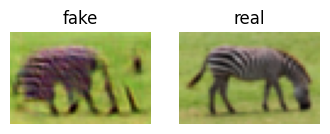

it scale 5:  30%|██▉       | 599/2000 [00:32<01:16, 18.42it/s]

[scale 5 | it 600]  Lips ≈ 1.53
[scale 5 | it 600]  LR = 5.00e-04


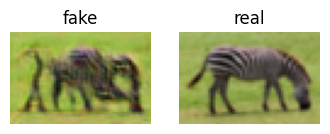

it scale 5:  40%|███▉      | 799/2000 [00:43<01:04, 18.55it/s]

[scale 5 | it 800]  Lips ≈ 1.71
[scale 5 | it 800]  LR = 5.00e-04


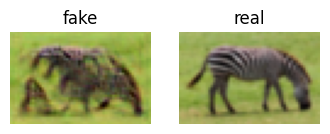

it scale 5:  50%|████▉     | 999/2000 [00:53<00:52, 19.07it/s]

[scale 5 | it 1000]  Lips ≈ 1.03
[scale 5 | it 1000]  LR = 5.00e-04


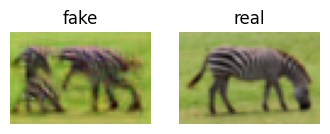

it scale 5:  60%|█████▉    | 1199/2000 [01:04<00:42, 19.05it/s]

[scale 5 | it 1200]  Lips ≈ 1.27
[scale 5 | it 1200]  LR = 5.00e-04


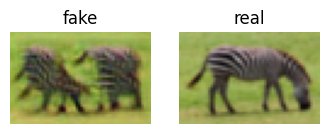

it scale 5:  70%|██████▉   | 1399/2000 [01:15<00:32, 18.75it/s]

[scale 5 | it 1400]  Lips ≈ 1.17
[scale 5 | it 1400]  LR = 5.00e-04


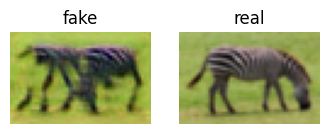

it scale 5:  80%|███████▉  | 1599/2000 [01:26<00:21, 18.88it/s]

[scale 5 | it 1600]  Lips ≈ 1.21
[scale 5 | it 1600]  LR = 5.00e-05


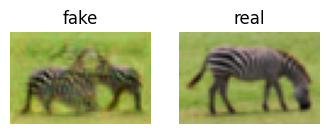

it scale 5:  90%|████████▉ | 1799/2000 [01:36<00:10, 19.02it/s]

[scale 5 | it 1800]  Lips ≈ 1.24
[scale 5 | it 1800]  LR = 5.00e-05


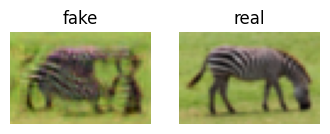

it scale 5: 100%|█████████▉| 1998/2000 [01:47<00:00, 19.06it/s]

[scale 5 | it 1999]  Lips ≈ 2.00
[scale 5 | it 1999]  LR = 5.00e-05


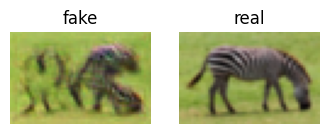

[init] copied weights from scale 5 → 4


it scale 4:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 4 | it 0]  Lips ≈ 1.49
[scale 4 | it 0]  LR = 5.00e-04


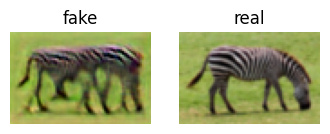

it scale 4:  10%|▉         | 199/2000 [00:10<01:38, 18.31it/s]

[scale 4 | it 200]  Lips ≈ 1.11
[scale 4 | it 200]  LR = 5.00e-04


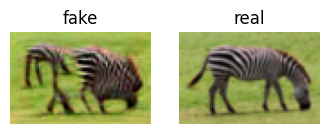

it scale 4:  20%|█▉        | 399/2000 [00:21<01:24, 19.03it/s]

[scale 4 | it 400]  Lips ≈ 1.96
[scale 4 | it 400]  LR = 5.00e-04


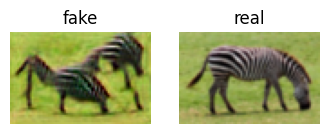

it scale 4:  30%|██▉       | 599/2000 [00:32<01:15, 18.46it/s]

[scale 4 | it 600]  Lips ≈ 1.36
[scale 4 | it 600]  LR = 5.00e-04


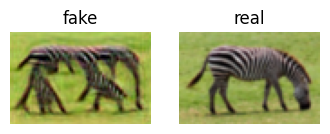

it scale 4:  40%|███▉      | 799/2000 [00:43<01:06, 18.13it/s]

[scale 4 | it 800]  Lips ≈ 1.07
[scale 4 | it 800]  LR = 5.00e-04


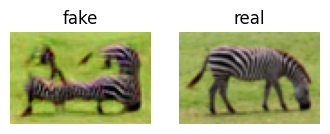

it scale 4:  50%|████▉     | 999/2000 [00:54<00:51, 19.41it/s]

[scale 4 | it 1000]  Lips ≈ 1.34
[scale 4 | it 1000]  LR = 5.00e-04


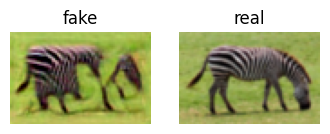

it scale 4:  60%|█████▉    | 1199/2000 [01:05<00:42, 18.80it/s]

[scale 4 | it 1200]  Lips ≈ 2.77
[scale 4 | it 1200]  LR = 5.00e-04


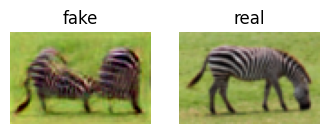

it scale 4:  70%|██████▉   | 1399/2000 [01:16<00:33, 18.05it/s]

[scale 4 | it 1400]  Lips ≈ 2.22
[scale 4 | it 1400]  LR = 5.00e-04


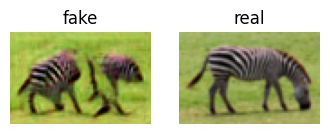

it scale 4:  80%|███████▉  | 1599/2000 [01:27<00:21, 18.32it/s]

[scale 4 | it 1600]  Lips ≈ 2.88
[scale 4 | it 1600]  LR = 5.00e-05


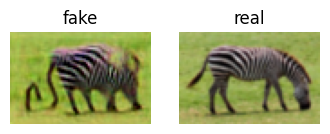

it scale 4:  90%|████████▉ | 1799/2000 [01:38<00:10, 18.67it/s]

[scale 4 | it 1800]  Lips ≈ 1.46
[scale 4 | it 1800]  LR = 5.00e-05


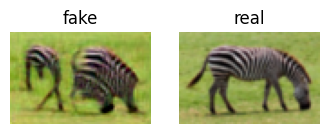

it scale 4: 100%|█████████▉| 1999/2000 [01:49<00:00, 17.87it/s]

[scale 4 | it 1999]  Lips ≈ 1.35
[scale 4 | it 1999]  LR = 5.00e-05


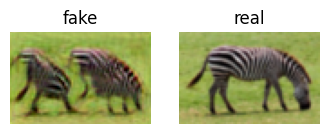

it scale 3:   0%|          | 0/2000 [00:00<?, ?it/s]           

[scale 3 | it 0]  Lips ≈ 0.06
[scale 3 | it 0]  LR = 5.00e-04


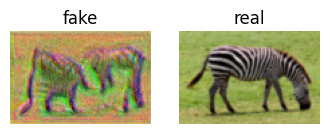

it scale 3:  10%|▉         | 199/2000 [00:14<02:12, 13.55it/s]

[scale 3 | it 200]  Lips ≈ 0.84
[scale 3 | it 200]  LR = 5.00e-04


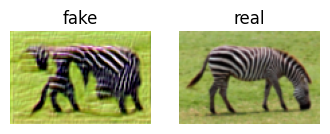

it scale 3:  20%|█▉        | 399/2000 [00:29<01:57, 13.57it/s]

[scale 3 | it 400]  Lips ≈ 1.09
[scale 3 | it 400]  LR = 5.00e-04


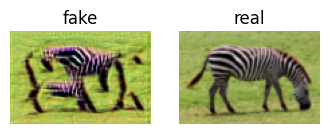

it scale 3:  30%|██▉       | 599/2000 [00:44<01:42, 13.61it/s]

[scale 3 | it 600]  Lips ≈ 1.72
[scale 3 | it 600]  LR = 5.00e-04


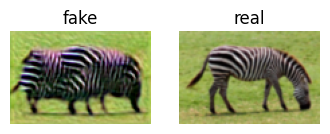

it scale 3:  40%|███▉      | 799/2000 [00:59<01:28, 13.59it/s]

[scale 3 | it 800]  Lips ≈ 2.07
[scale 3 | it 800]  LR = 5.00e-04


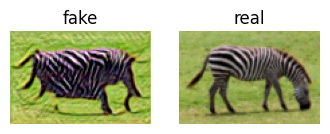

it scale 3:  50%|████▉     | 999/2000 [01:14<01:14, 13.48it/s]

[scale 3 | it 1000]  Lips ≈ 1.41
[scale 3 | it 1000]  LR = 5.00e-04


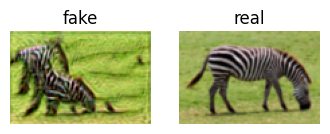

it scale 3:  60%|█████▉    | 1199/2000 [01:29<00:59, 13.45it/s]

[scale 3 | it 1200]  Lips ≈ 1.36
[scale 3 | it 1200]  LR = 5.00e-04


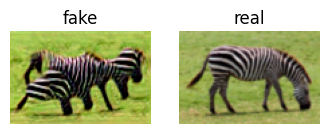

it scale 3:  70%|██████▉   | 1399/2000 [01:43<00:44, 13.46it/s]

[scale 3 | it 1400]  Lips ≈ 2.97
[scale 3 | it 1400]  LR = 5.00e-04


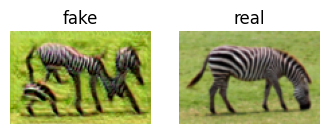

it scale 3:  80%|███████▉  | 1599/2000 [01:58<00:29, 13.55it/s]

[scale 3 | it 1600]  Lips ≈ 2.01
[scale 3 | it 1600]  LR = 5.00e-05


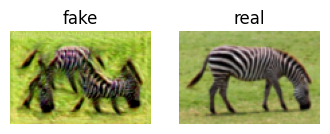

it scale 3:  90%|████████▉ | 1799/2000 [02:13<00:14, 13.68it/s]

[scale 3 | it 1800]  Lips ≈ 2.15
[scale 3 | it 1800]  LR = 5.00e-05


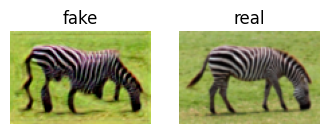

it scale 3: 100%|█████████▉| 1999/2000 [02:28<00:00, 13.49it/s]

[scale 3 | it 1999]  Lips ≈ 2.34
[scale 3 | it 1999]  LR = 5.00e-05


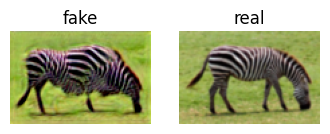

[init] copied weights from scale 3 → 2


it scale 2:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 2 | it 0]  Lips ≈ 2.19
[scale 2 | it 0]  LR = 5.00e-04


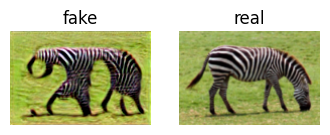

it scale 2:  10%|█         | 200/2000 [00:21<03:09,  9.52it/s]

[scale 2 | it 200]  Lips ≈ 1.25
[scale 2 | it 200]  LR = 5.00e-04


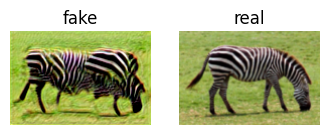

it scale 2:  20%|██        | 400/2000 [00:42<02:48,  9.48it/s]

[scale 2 | it 400]  Lips ≈ 1.29
[scale 2 | it 400]  LR = 5.00e-04


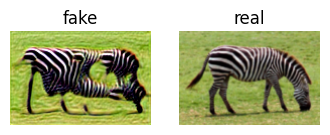

it scale 2:  30%|███       | 600/2000 [01:03<02:28,  9.46it/s]

[scale 2 | it 600]  Lips ≈ 1.50
[scale 2 | it 600]  LR = 5.00e-04


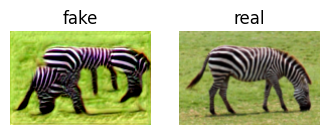

it scale 2:  40%|████      | 800/2000 [01:24<02:06,  9.46it/s]

[scale 2 | it 800]  Lips ≈ 1.49
[scale 2 | it 800]  LR = 5.00e-04


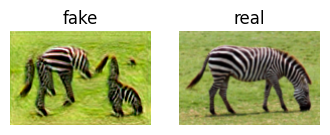

it scale 2:  50%|█████     | 1000/2000 [01:45<01:45,  9.49it/s]

[scale 2 | it 1000]  Lips ≈ 1.45
[scale 2 | it 1000]  LR = 5.00e-04


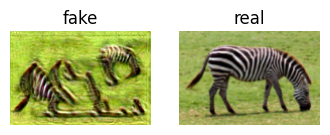

it scale 2:  60%|██████    | 1200/2000 [02:06<01:24,  9.52it/s]

[scale 2 | it 1200]  Lips ≈ 1.54
[scale 2 | it 1200]  LR = 5.00e-04


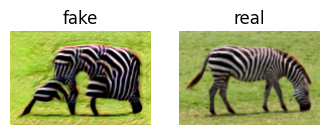

it scale 2:  70%|███████   | 1400/2000 [02:27<01:03,  9.48it/s]

[scale 2 | it 1400]  Lips ≈ 1.70
[scale 2 | it 1400]  LR = 5.00e-04


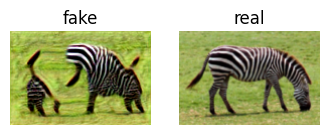

it scale 2:  80%|████████  | 1600/2000 [02:49<00:41,  9.54it/s]

[scale 2 | it 1600]  Lips ≈ 1.54
[scale 2 | it 1600]  LR = 5.00e-05


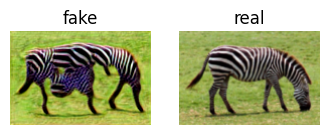

it scale 2:  90%|█████████ | 1800/2000 [03:10<00:21,  9.50it/s]

[scale 2 | it 1800]  Lips ≈ 2.74
[scale 2 | it 1800]  LR = 5.00e-05


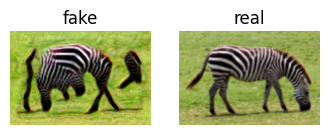

it scale 2: 100%|█████████▉| 1999/2000 [03:31<00:00,  9.40it/s]

[scale 2 | it 1999]  Lips ≈ 1.48
[scale 2 | it 1999]  LR = 5.00e-05


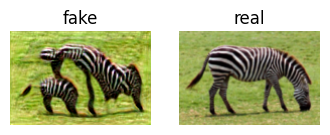

[init] copied weights from scale 2 → 1


it scale 1:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 1 | it 0]  Lips ≈ 1.68
[scale 1 | it 0]  LR = 5.00e-04


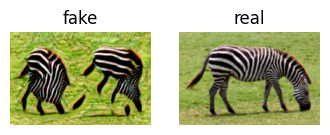

it scale 1:  10%|█         | 200/2000 [00:37<05:40,  5.29it/s]

[scale 1 | it 200]  Lips ≈ 0.96
[scale 1 | it 200]  LR = 5.00e-04


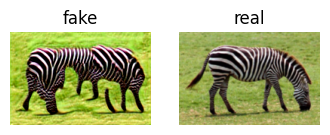

it scale 1:  20%|██        | 400/2000 [01:15<05:02,  5.29it/s]

[scale 1 | it 400]  Lips ≈ 1.10
[scale 1 | it 400]  LR = 5.00e-04


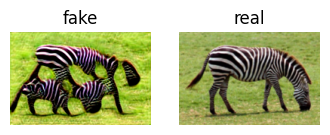

it scale 1:  30%|███       | 600/2000 [01:53<04:24,  5.30it/s]

[scale 1 | it 600]  Lips ≈ 1.37
[scale 1 | it 600]  LR = 5.00e-04


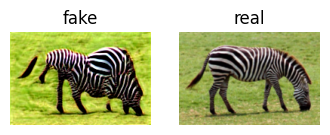

it scale 1:  40%|████      | 800/2000 [02:31<03:46,  5.29it/s]

[scale 1 | it 800]  Lips ≈ 1.76
[scale 1 | it 800]  LR = 5.00e-04


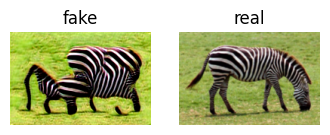

it scale 1:  50%|█████     | 1000/2000 [03:09<03:08,  5.30it/s]

[scale 1 | it 1000]  Lips ≈ 2.35
[scale 1 | it 1000]  LR = 5.00e-04


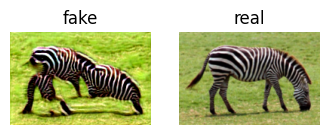

it scale 1:  60%|██████    | 1200/2000 [03:47<02:31,  5.29it/s]

[scale 1 | it 1200]  Lips ≈ 1.88
[scale 1 | it 1200]  LR = 5.00e-04


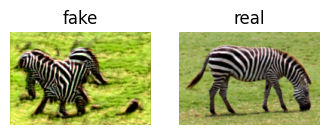

it scale 1:  70%|███████   | 1400/2000 [04:25<01:53,  5.28it/s]

[scale 1 | it 1400]  Lips ≈ 1.73
[scale 1 | it 1400]  LR = 5.00e-04


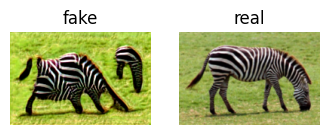

it scale 1:  80%|████████  | 1600/2000 [05:03<01:15,  5.28it/s]

[scale 1 | it 1600]  Lips ≈ 1.71
[scale 1 | it 1600]  LR = 5.00e-05


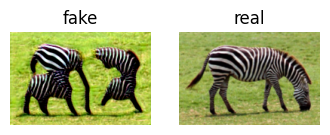

it scale 1:  90%|█████████ | 1800/2000 [05:40<00:37,  5.29it/s]

[scale 1 | it 1800]  Lips ≈ 1.81
[scale 1 | it 1800]  LR = 5.00e-05


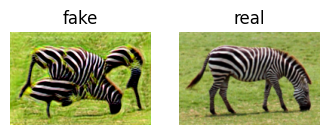

it scale 1: 100%|█████████▉| 1999/2000 [06:18<00:00,  5.28it/s]

[scale 1 | it 1999]  Lips ≈ 1.73
[scale 1 | it 1999]  LR = 5.00e-05


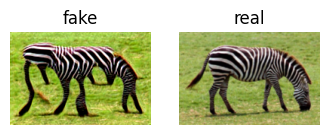

[init] copied weights from scale 1 → 0


it scale 0:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 0 | it 0]  Lips ≈ 1.63
[scale 0 | it 0]  LR = 5.00e-04


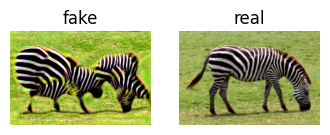

it scale 0:  10%|█         | 200/2000 [00:49<07:25,  4.04it/s]

[scale 0 | it 200]  Lips ≈ 1.76
[scale 0 | it 200]  LR = 5.00e-04


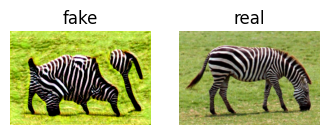

it scale 0:  20%|██        | 400/2000 [01:39<06:35,  4.04it/s]

[scale 0 | it 400]  Lips ≈ 1.79
[scale 0 | it 400]  LR = 5.00e-04


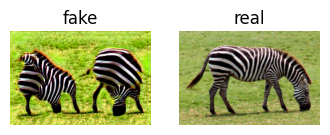

it scale 0:  30%|███       | 600/2000 [02:28<05:46,  4.04it/s]

[scale 0 | it 600]  Lips ≈ 3.57
[scale 0 | it 600]  LR = 5.00e-04


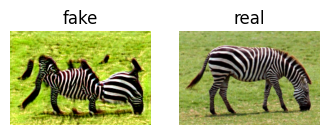

it scale 0:  40%|████      | 800/2000 [03:18<04:57,  4.03it/s]

[scale 0 | it 800]  Lips ≈ 2.45
[scale 0 | it 800]  LR = 5.00e-04


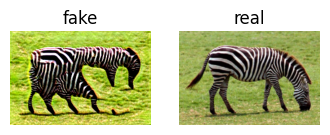

it scale 0:  50%|█████     | 1000/2000 [04:08<04:08,  4.03it/s]

[scale 0 | it 1000]  Lips ≈ 1.81
[scale 0 | it 1000]  LR = 5.00e-04


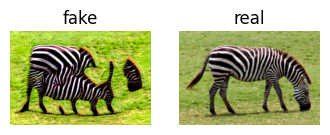

it scale 0:  60%|██████    | 1200/2000 [04:57<03:18,  4.03it/s]

[scale 0 | it 1200]  Lips ≈ 2.32
[scale 0 | it 1200]  LR = 5.00e-04


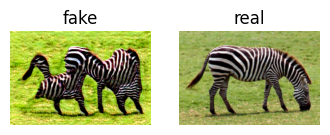

it scale 0:  70%|███████   | 1400/2000 [05:47<02:28,  4.03it/s]

[scale 0 | it 1400]  Lips ≈ 4.65
[scale 0 | it 1400]  LR = 5.00e-04


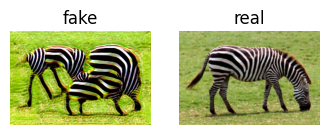

it scale 0:  80%|████████  | 1600/2000 [06:36<01:39,  4.04it/s]

[scale 0 | it 1600]  Lips ≈ 2.20
[scale 0 | it 1600]  LR = 5.00e-05


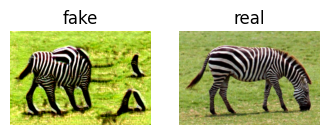

it scale 0:  90%|█████████ | 1800/2000 [07:26<00:49,  4.03it/s]

[scale 0 | it 1800]  Lips ≈ 2.15
[scale 0 | it 1800]  LR = 5.00e-05


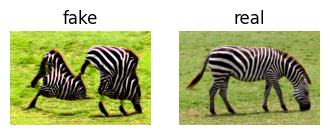

it scale 0: 100%|█████████▉| 1999/2000 [08:16<00:00,  4.04it/s]

[scale 0 | it 1999]  Lips ≈ 3.71
[scale 0 | it 1999]  LR = 5.00e-05


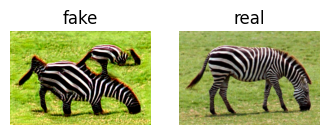

In [9]:
torch.random.manual_seed(0)

# params
lambda_gp    = 10
lr             = 5e-4 # celui du github
betas            = (0.5, 0.999) # pareil
n_Discriminator  = 5 # pif
n_Generator      = 2 # pif
iter_per_scale   = 2000 # github
alpha_rec      = 10 # gith
beta_sigma   = 0.1 # git
debug          = True
b          = 1  # batch size   
N = len(scales)


for G in Genarators:
    G.apply(weights_init)
for D in Discriminators:
    D.apply(weights_init)

# reset des optim.
optimizer_G, optimizer_D = [], []
for i in range(N):
    optimizer_G.append(optim.Adam(Genarators[i].parameters(), lr=lr, betas=betas))
    optimizer_D.append(optim.Adam(Discriminators[i].parameters(), lr=lr, betas=betas))

# --- LR schedulers -----------------------------------------------------------
# Each StepLR will keep the LR unchanged for 1 600 iterations, then multiply it
# by 0.1 once, and keep the new value for the remaining ~400 iterations.
scheduler_G, scheduler_D = [], []

step_size   = 1600          # when to trigger the decay
gamma       = 0.1            # multiplicative factor

for opt_G, opt_D in zip(optimizer_G, optimizer_D):
    scheduler_G.append(
        torch.optim.lr_scheduler.StepLR(opt_G, step_size=step_size, gamma=gamma)
    )
    scheduler_D.append(
        torch.optim.lr_scheduler.StepLR(opt_D, step_size=step_size, gamma=gamma)
    )


z_star   = torch.randn_like(scales[-1])               # bruit fixe
sigma_n  = [1.] * N
x_rec    = [None] * N
gen_image = [torch.zeros_like(scales[-1]).to(device)]
       

@torch.no_grad()
def regenerate_prev_full(k):
    """
    Reconstruit un prev_img pour l'échelle k en:
      +  partant d'une image nulle au coarse (N-1),
      + appliquant *tous* les G gelés (N-1 … k+1) avec nouveau bruit,
      +  upsamplant le résultat (k+1) → résolution de k.
    """
    if k == N-1:                                    # échelle coarse → zeros
        return torch.zeros_like(scales[k]).to(device)

    # scale la plus petite
    img = torch.zeros_like(scales[-1]).to(device)   
    z   = torch.randn_like(img) * sigma_n[N-1]
    img = Genarators[N-1](z)                       

    # on remonte le réseau
    for s in range(N-2, k, -1):                     
        img_up = F.interpolate(img,
                               size=scales[s].shape[2:],
                               mode='bilinear', align_corners=False)
        z      = torch.randn_like(img_up) * sigma_n[s]
        img    = Genarators[s](z + img_up) + img_up

    prev_img = F.interpolate(img,
                             size=scales[k].shape[2:],
                             mode='bilinear', align_corners=False)
    return prev_img

def lipconstant(D, x, y):
    
    b = x.size(0)
    if y.size(0) != b:
        raise ValueError("batch sizes differ")

    alpha = torch.rand((b,1,1,1), device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_(True)

    Di = D(interp).mean()                    # mean sinon ça me donnait des truc abbérant
    gradients = torch.autograd.grad(
        outputs=Di, inputs=interp,
        grad_outputs=torch.ones_like(Di),    
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]

    eps = 1e-12
    gradients_norm = torch.sqrt(gradients.flatten(1).pow(2).sum(1) + eps)
    return gradients_norm.mean()

# trainning toutes les scales
for n in range(N):
    current_res  = N - n - 1          
    Gk = Genarators[current_res].train()
    Dk = Discriminators[current_res].train()
    xk_real = scales[current_res].to(device)
    
    
    if current_res < N-1:                          
        G_prev = Genarators[current_res + 1]
        D_prev = Discriminators[current_res + 1]

        def same_channels(net_a, net_b):
            """return True if first conv out-channels match"""
            for m_a, m_b in zip(net_a.modules(), net_b.modules()):
                if isinstance(m_a, torch.nn.Conv2d):
                    return m_a.out_channels == m_b.out_channels
            return False

        if same_channels(Gk, G_prev):              
            Gk.load_state_dict(G_prev.state_dict(), strict=True)
            Dk.load_state_dict(D_prev.state_dict(), strict=True)
            if debug:
                print(f"[init] copied weights from scale {current_res+1} → {current_res}")

    # NB: from here on, use *Gk* / *Dk*; they already sit in the
    #     Genarators / Discriminators lists, so nothing else changes.
    Gk.train();  Dk.train()
    # (re-attach the optimisers in case parameters were just overwritten)
    opt_G = optimizer_G[current_res]
    opt_D = optimizer_D[current_res]
    

# Calcul ecart type nécessaire pour le bruit.
    if current_res < N-1:
        up_rec = F.interpolate(x_rec[current_res+1],
                               size=xk_real.shape[2:], mode='bilinear', align_corners=False)

        # σ_n = β · RMSE((x_rec[n+1]↑), x_n) / RMSE(0, x_n) # formule trouvé je sais plus ou. 
        num   = F.mse_loss(up_rec, xk_real)             
        denom = F.mse_loss(torch.zeros_like(xk_real), xk_real)
        sigma_n[current_res] = beta_sigma * torch.sqrt(num / denom)   
    else:
        sigma_n[current_res] = torch.tensor(1, device=device)

    # itérations par scale
    for it in tqdm(range(iter_per_scale), desc=f"it scale {current_res}", leave=False):

        # prev_img tiré fraichement
        with torch.no_grad():
            prev_img = regenerate_prev_full(current_res)

        # trainning discriminateur
        for _ in range(n_Discriminator):
            opt_D.zero_grad()
            z = torch.randn_like(prev_img) * sigma_n[current_res]
            fake = Gk(z + prev_img) + prev_img

            loss_D = Dk(fake.detach()).mean() - Dk(xk_real).mean()

            # gradient penalty
            alpha = torch.rand(b,1,1,1,device=device)
            interp = (alpha*xk_real + (1-alpha)*fake.detach()).requires_grad_(True)
            grad_out = Dk(interp).mean()
            grad = torch.autograd.grad(grad_out, interp, torch.ones_like(grad_out),
                                       create_graph=True, retain_graph=True, only_inputs=True)[0]
            gp = lambda_gp * ((grad.flatten(1).norm(2,dim=1)-1)**2).mean()
            (loss_D + gp).backward()
            opt_D.step()

       

        for g_idx in range(n_Generator):
            opt_G.zero_grad()
            z = torch.randn_like(prev_img) * sigma_n[current_res]
            fake = Gk(z + prev_img) + prev_img
            adv_G = -Dk(fake).mean()

            # ----- Reconstruction eq. 5 -----
            if current_res == N-1:                         # coarse
                rec_in = z_star                             # MOD (z_star)
                rec_out = Gk(rec_in)                       # pas de upsample
            else:                                          # n < N
                up_fixed = F.interpolate(x_rec[current_res+1],
                                          size=xk_real.shape[2:], mode='bilinear', align_corners=False)
                rec_in = up_fixed                          # MOD (bruit = 0)
                rec_out = Gk(rec_in) + up_fixed            # MOD

            Lrec = F.mse_loss(rec_out, xk_real)
            (adv_G + alpha_rec * Lrec).backward()
            opt_G.step()
        
        # ---- advance LR scheduler *once* for this outer iteration
        scheduler_D[current_res].step()
        scheduler_G[current_res].step()
        
        # logs
        if debug and (it % 200 == 0 or it==iter_per_scale-1):
            # pas de torch.no_grad() ici : on a besoin du backward dans lipconstant
            lips = lipconstant(Dk, fake.detach(), xk_real)
            print(f"[scale {current_res} | it {it}]  Lips ≈ {lips:.2f}")
            current_lr = opt_G.param_groups[0]['lr']
            print(f"[scale {current_res} | it {it}]  LR = {current_lr:.2e}")

            with torch.no_grad():                     # on garde no_grad pour l’affichage
                plt.figure(figsize=(4,2))
                plt.subplot(1,2,1); plt.imshow(pil_from_minus1to1(fake[0].cpu())); plt.axis('off'); plt.title('fake')
                plt.subplot(1,2,2); plt.imshow(pil_from_minus1to1(xk_real[0].cpu()));        plt.axis('off'); plt.title('real')
                plt.show()
    # fige G_k et stocke fake pour l’échelle au-dessus 
    with torch.no_grad():
        gen_image.append(fake.detach())
        if current_res == N-1:
            x_rec[current_res] = Gk(z_star)                              # NEW (bruit fixe)
        else:
            up_rec_k = F.interpolate(x_rec[current_res+1], size=xk_real.shape[2:], mode='bilinear', align_corners=False)
            x_rec[current_res] = Gk(up_rec_k) + up_rec_k                 # NEW (bruit 0)
        Gk.eval()
        for p in Gk.parameters(): 
            p.requires_grad_(False)

SAVING GENERATORS AND NECESSARY PARAMS

In [12]:
# ==== SAVE GENERATORS ========================================================
import os, datetime, torch, json

model_name = "weird" 
image_name = "zebre"                   
model_dir  = os.path.join("models", image_name,model_name)
weights_fp = os.path.join(model_dir, "generators.pt")
descr_fp   = os.path.join(model_dir, "Description.txt")
sigma_fp   = os.path.join(model_dir, "sigma_n.json")
zstar_fp   = os.path.join(model_dir, "z_star.pt")    # ← chemin pour z_star

if os.path.exists(model_dir):
    print(f"ATTENTION : Un modèle nommé '{model_name}' existe déjà dans '{model_dir}'.")
    print("   → Choisis un autre nom pour ne pas l'écraser.")
else:
    os.makedirs(model_dir, exist_ok=True)

    # 1) sauvegarde des poids : liste d'état (un par G_k)
    torch.save([G.state_dict() for G in Genarators], weights_fp)

    # 2) petit fichier description (texte lisible)
    description = {
        "date"           : datetime.datetime.now().isoformat(timespec="seconds"),
        "N"              : N,
        "lambda_gp"      : lambda_gp,
        "r"                 : float(4/3),
        "lr"             : lr,
        "betas"          : betas,
        "n_Discriminator": n_Discriminator,
        "n_Generator"    : n_Generator,
        "iter_per_scale" : iter_per_scale,
        "alpha_rec"      : alpha_rec,
        "beta_sigma"     : beta_sigma,
        "comment"        : "Sin Gan avec de la data aug sur l'image réele. Xrec est toujours sur l'image de base et on a un batch de 2 la",
    }
    with open(descr_fp, "w", encoding="utf-8") as f:
        for k, v in description.items():
            f.write(f"{k}: {v}\n")

    # 3) sauvegarde de la liste sigma_n
    sigma_list = []
    for s in sigma_n:
        # si s est un tensor scalaire, on fait s.item(), sinon on lève une erreur
        if torch.is_tensor(s):
            sigma_list.append(s.item())
        else:
            sigma_list.append(float(s))
    with open(sigma_fp, "w", encoding="utf-8") as f:
        json.dump(sigma_list, f)


    # 4) génération et sauvegarde de z_star
    #    remplace (h, w) par la forme souhaitée
    torch.save(z_star, zstar_fp)

    print(f"Générateurs sauvegardés     -> {weights_fp}")
    print(f"Description créée           -> {descr_fp}")
    print(f"sigma_n sauvegardé          -> {sigma_fp}")
    print(f"z_star sauvegardé           -> {zstar_fp}")


Générateurs sauvegardés     -> models/zebre/weird/generators.pt
Description créée           -> models/zebre/weird/Description.txt
sigma_n sauvegardé          -> models/zebre/weird/sigma_n.json
z_star sauvegardé           -> models/zebre/weird/z_star.pt


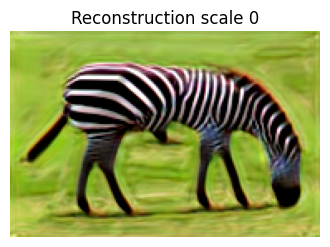

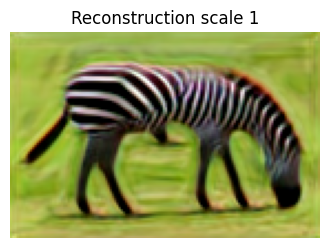

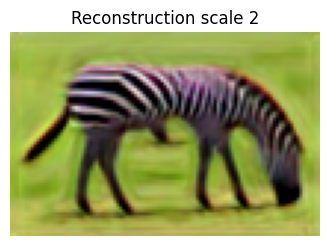

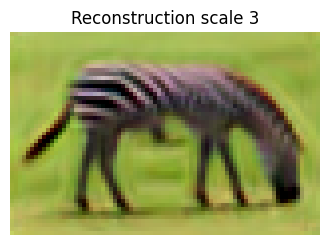

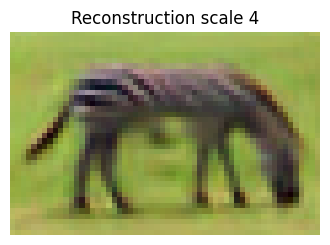

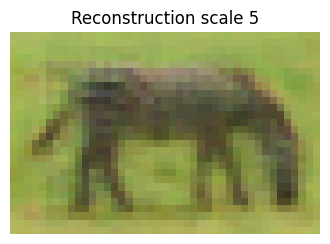

In [11]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def plot_reconstructions(x_rec):
    for i, rec in enumerate(x_rec):
        if rec is None:
            continue
        img = rec.detach().cpu().squeeze()
        plt.figure(figsize=(4,4))
        plt.title(f"Reconstruction scale {i}")
        plt.imshow(pil_from_minus1to1(img))
        plt.axis('off')
        plt.show()

plot_reconstructions(x_rec[1:])